In [ ]:
# !apt-get install git-lfs
# !git lfs install  
# !git clone https://github.com/calico/spatial_lda.git
# !pip install lifelines
# !pip install palettable


# package location: /wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/spatial_lda

In [1]:
import os
import sys

os.chdir("/wynton/home/engelhardt/chwu/Projects/HubID/SpatialLDA")
PATH_TO_MODELS = f'./models/'
#PATH_TO_DF_PKL = f'./data//spleen_df.pkl'
PATH_TO_FEATURES_PKL = f'./data/cells_features_default_sub_region.pkl'

# paths = [
#   PATH_TO_MODELS,
#   PATH_TO_SPLEEN_DF_PKL
# ]

# paths_exist = {path: os.path.exists(path) for path in paths}
# display(paths_exist)
# assert all(paths_exist.values())


In [16]:
%load_ext autoreload
%autoreload 2

import functools
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import tqdm
# Spatial LDA imports
from spatial_lda.featurization import neighborhood_to_cluster, neighborhood_to_marker_continuous
from spatial_lda.featurization import make_nearest_neighbor_graph
from spatial_lda.featurization import make_merged_difference_matrices
from spatial_lda.featurization import featurize_samples
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
import spatial_lda.model

N_PARALLEL_PROCESSES = 8#@param
TRAIN_SIZE_FRACTION = 0.99 #@param
N_TOPICS_LIST = [3, 5, 8, 10] #@param

logger = logging.getLogger()
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# visualization parameters
blue = sns.color_palette()[0]
green = sns.color_palette()[1]
red = sns.color_palette()[2]
sns.set_context("paper",font_scale=1)
sns.set_style('white')
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

In [6]:
# mtx=scipy.sparse.load_npz("../neighbor_smooth/Data/G4423_15_neighbor_sums.npz")
# with open("../neighbor_smooth//Data/G4423_15_neighbor_sums_colnames.csv", "r+") as file1:
#     # Reading form a file
#     colnames=file1.read()
    
# colnames=colnames.strip("\n").split(",")


mtx=pd.read_csv("/gladstone/engelhardt/pelka-collaboration/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_by_gene.csv")

In [7]:
mtx=mtx.iloc[:,1:]
mtx

,COL3A1,HLA-E,VIM,JUN,STMN1,ASCL2,TIMP1,HLA-DRB1,DNAJB1,PSMB8,...,Blank-27,Blank-68,UBE2C,Blank-62,SPP1,Blank-17,Blank-40,COL10A1,Blank-9,Blank-59
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546284,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546285,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546286,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546287,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
markers= mtx.columns
markers=markers.tolist()
len(markers)

550

In [ ]:
# mtx2=scipy.sparse.csr_matrix(np.array(mtx))
# scipy.sparse.save_npz('./Data/G4423_15_neighbor_sums.npz', mtx2)

In [ ]:
# mtx=pd.DataFrame(mtx.todense())
# mtx.columns=colnames
# mtx=mtx.iloc[:,1:]
# mtx

In [9]:
# import spatial info
#meta=pd.read_csv('/wynton/group/gladstone/users/cywu/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
meta=pd.read_csv('/gladstone/engelhardt/pelka-collaboration/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
coordinates0=np.array(meta[['center_x', 'center_y']])
coordinates=coordinates0
coordinates


array([[11034.14202732,  2966.53593962],
       [11038.9741895 ,  2965.83061915],
       [11058.40741954,  2981.00772623],
       ...,
       [11842.5858035 ,  8817.65049918],
       [11746.48760914,  8818.06972971],
       [11733.95617749,  8819.07830778]])

In [10]:
# flip y
coordinates[:,1]=max(coordinates0[:,1])-coordinates0[:,1]

In [11]:
idx=range((mtx.shape[0]))
print(mtx.loc[idx].shape)
print(mtx.shape)

(546289, 550)
(546289, 550)


In [ ]:
#print(list(mtx.columns[0:550]))

# Generate inputs for running Spatial LDA

In [12]:
mtx['isb']=True
mtx['sample']='G4423'
mtx['sample.X']=coordinates[:,0]
mtx['sample.Y']=coordinates[:,1]



In [13]:
# subsample and generate dic
import random
random.seed(100)
#idx=random.sample(range((mtx.shape[0])), 5000)#int(mtx.shape[0]*0.1))
idx=np.array([*range(mtx.shape[0])])
idx=idx[((coordinates[:,0]>2500) & (coordinates[:,0]<5000)) & ((coordinates[:,1]<max(coordinates[:,1])) & (coordinates[:,1]>(max(coordinates[:,1])-2500)))]

df_dict = {'G4423': mtx.loc[idx]}
#df_dict['G4423_2']=mtx.loc[idx[1000:2000]]
df_dict

{'G4423':         COL3A1  HLA-E  VIM  JUN  STMN1  ASCL2  TIMP1  HLA-DRB1  DNAJB1  PSMB8  \
 2457       0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
 2458       0.0    0.0  1.0  0.0    0.0    0.0    0.0       0.0     2.0    0.0   
 2459       0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
 2460       0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
 2461       1.0    7.0  1.0  0.0    0.0    0.0    0.0       0.0     1.0    0.0   
 ...        ...    ...  ...  ...    ...    ...    ...       ...     ...    ...   
 526713     0.0    1.0  0.0  2.0    0.0    0.0    0.0       0.0     0.0    0.0   
 526714     0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
 526715     0.0    0.0  0.0  1.0    0.0    0.0    0.0       0.0     0.0    0.0   
 526716     0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
 526717     0.0    0.0  0.0  0.0    0.0    0.0    0.0       0.0     0.0    0.0   
 
     

In [17]:
# Featurize the data
#%%time
for df in df_dict.values():
    df['x'] = df['sample.X']
    df['y'] = df['sample.Y']
#wt_samples = [ x for x in codex_df_dict.keys() if x.startswith("BALBc")]
#spleen_dfs = dict(zip(wt_samples, [ codex_df_dict[x] for x in wt_samples]))

neighborhood_feature_fn = functools.partial(neighborhood_to_marker_continuous, 
                                              markers=markers)  

cells_features = featurize_samples(df_dict, neighborhood_feature_fn, 100,'isb',
                             'sample.X', 'sample.Y', include_anchors=True, #all cells are ahcnors
                             n_processes=N_PARALLEL_PROCESSES)


#featurize_spleens(spleen_dfs, neighborhood_to_cluster, radius=100,n_processes=N_PARALLEL_PROCESSES)
with open(PATH_TO_FEATURES_PKL, 'wb') as f:
    pickle.dump(cells_features, f)


100%|███████████████████████████████████████████| 1/1 [33:28<00:00, 2008.10s/it]


In [ ]:
# with open(PATH_TO_FEATURES_PKL, 'rb') as f:
#     cells_features2=pickle.load(f)

In [27]:
cells_features

,COL3A1,HLA-E,VIM,JUN,STMN1,ASCL2,TIMP1,HLA-DRB1,DNAJB1,PSMB8,...,Blank-27,Blank-68,UBE2C,Blank-62,SPP1,Blank-17,Blank-40,COL10A1,Blank-9,Blank-59
"(G4423, 2457)",330.0,190.0,175.0,45.0,6.0,12.0,9.0,15.0,81.0,6.0,...,1.0,0.0,11.0,1.0,10.0,3.0,2.0,0.0,0.0,1.0
"(G4423, 2458)",163.0,219.0,103.0,35.0,5.0,6.0,7.0,12.0,131.0,12.0,...,1.0,0.0,7.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0
"(G4423, 2459)",181.0,270.0,88.0,40.0,7.0,25.0,2.0,6.0,184.0,18.0,...,0.0,1.0,11.0,0.0,16.0,0.0,0.0,1.0,0.0,0.0
"(G4423, 2460)",196.0,270.0,106.0,48.0,10.0,27.0,3.0,8.0,199.0,20.0,...,0.0,1.0,13.0,0.0,16.0,0.0,0.0,1.0,0.0,0.0
"(G4423, 2461)",149.0,231.0,108.0,35.0,4.0,10.0,8.0,12.0,149.0,14.0,...,1.0,0.0,6.0,1.0,10.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(G4423, 526713)",12.0,135.0,10.0,68.0,0.0,0.0,0.0,4.0,19.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(G4423, 526714)",7.0,138.0,8.0,57.0,0.0,0.0,0.0,4.0,13.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(G4423, 526715)",10.0,149.0,11.0,73.0,0.0,0.0,0.0,3.0,19.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(G4423, 526716)",13.0,137.0,7.0,68.0,0.0,0.0,0.0,4.0,16.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
difference_matrices = make_merged_difference_matrices(cells_features, df_dict,
                                                             'sample.X', 'sample.Y')
all_sample_idxs = cells_features.index.map(lambda x: x[0])
_sets = train_test_split(cells_features, 
                         test_size=1. - TRAIN_SIZE_FRACTION,
                         stratify=all_sample_idxs)
train_cells_features, test_cells__features = _sets
train_difference_matrices = make_merged_difference_matrices(
    train_cells_features, df_dict,
    'sample.X', 'sample.Y')
train_idxs = train_cells_features.index.map(lambda x: x[0])

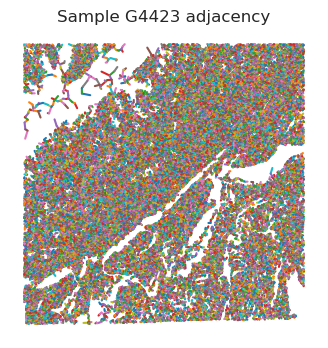

In [19]:
from spatial_lda.visualization import plot_adjacency_graph

def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(difference_matrices)

plot_samples_in_a_row(cells_features, _plot_fn, df_dict)

In [20]:
from spatial_lda.visualization import plot_samples_in_a_row
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from spatial_lda.visualization import plot_samples_in_a_row
with PdfPages('./plots/G4423_default_subregion_adjacency.pdf') as pdf_pages:
    # df1 = dftest.select_dtypes([np.int, np.float, np.object])
    # for i, col in enumerate(N_TOPICS_LIST):
    #     figu = plt.figure(i)
    #     plot = sns.countplot(x=col, data=df1)
    #     pdf_pages.savefig(figu)
    plt.figure()
    plot_samples_in_a_row(cells_features, _plot_fn, df_dict)
    pdf_pages.savefig()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [ ]:
cells_features

# Spatial LDA results

In [29]:
#N_TOPICS_LIST = [3, 5, 8, 10] #@param
N_TOPICS_LIST = [12, 15, 18] #@param
N_TOPICS_LIST

[12, 15, 18]

In [ ]:
train_cells_features

In [30]:
from spatial_lda.model import order_topics_consistently
spatial_lda_models = {}  
difference_penalty = 0.25  
for n_topics in N_TOPICS_LIST:
  path_to_train_model = '_'.join((f'{PATH_TO_MODELS}/training_default_subregion',
                                  f'penalty={difference_penalty}',
                                  f'topics={n_topics}',
                                  f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'
  if not os.path.exists(path_to_train_model):
    print(f'Running n_topics={n_topics}, d={difference_penalty}\n')
    spatial_lda_model = spatial_lda.model.train(sample_features=train_cells_features, 
                                                difference_matrices=train_difference_matrices,
                                                difference_penalty=difference_penalty,
                                                n_topics=n_topics,
                                                n_parallel_processes=N_PARALLEL_PROCESSES,                                                                         
                                                verbosity=1,
                                                admm_rho=0.1,
                                                primal_dual_mu=1e+5)
    spatial_lda_models[n_topics] = spatial_lda_model
    with open(path_to_train_model, 'wb') as f:
      pickle.dump(spatial_lda_model, f)    
  else:
    with open(path_to_train_model, 'rb') as f:
      spatial_lda_models[n_topics] = pickle.load(f)
      
order_topics_consistently(spatial_lda_models.values())     

INFO:root:>>> Starting iteration 0


Running n_topics=12, d=0.25



LDA training: 100%|███████████████████████████████| 5/5 [01:08<00:00, 13.69s/it]
INFO:root:>>> Iteration 0, M-step took 106.04865860939026 seconds.

Update xi: 100%|████████████████████████████████| 1/1 [34:32<00:00, 2072.38s/it]
INFO:root:>>> Iteration 0, E-step took 2073.9522001743317 seconds.
INFO:root:>>> Starting iteration 1
LDA training: 100%|███████████████████████████████| 5/5 [01:44<00:00, 20.80s/it]
INFO:root:>>> Iteration 1, M-step took 151.4430012702942 seconds.

Update xi: 100%|████████████████████████████████| 1/1 [33:01<00:00, 1981.33s/it]
INFO:root:>>> Iteration 1, E-step took 1983.1649098396301 seconds.
INFO:root:>>> Starting iteration 2
LDA training: 100%|███████████████████████████████| 5/5 [01:39<00:00, 19.97s/it]
INFO:root:>>> Iteration 2, M-step took 149.7445352077484 seconds.

Update xi: 100%|████████████████████████████████| 1/1 [32:51<00:00, 1971.24s/it]
INFO:root:>>> Iteration 2, E-step took 1972.8380155563354 seconds.
LDA training: 100%|██████████████████████

Running n_topics=15, d=0.25



LDA training: 100%|███████████████████████████████| 5/5 [01:11<00:00, 14.31s/it]
INFO:root:>>> Iteration 0, M-step took 111.60497260093689 seconds.

Update xi: 100%|████████████████████████████████| 1/1 [39:22<00:00, 2362.19s/it]
INFO:root:>>> Iteration 0, E-step took 2363.918809890747 seconds.
INFO:root:>>> Starting iteration 1
LDA training: 100%|███████████████████████████████| 5/5 [01:44<00:00, 20.99s/it]
INFO:root:>>> Iteration 1, M-step took 158.1019856929779 seconds.

Update xi: 100%|████████████████████████████████| 1/1 [39:38<00:00, 2378.67s/it]
INFO:root:>>> Iteration 1, E-step took 2380.375075340271 seconds.
INFO:root:>>> Starting iteration 2
LDA training: 100%|███████████████████████████████| 5/5 [01:48<00:00, 21.73s/it]
INFO:root:>>> Iteration 2, M-step took 162.74713706970215 seconds.

Update xi: 100%|████████████████████████████████| 1/1 [39:33<00:00, 2373.20s/it]
INFO:root:>>> Iteration 2, E-step took 2375.164523124695 seconds.
LDA training: 100%|████████████████████████

Running n_topics=18, d=0.25



LDA training: 100%|███████████████████████████████| 5/5 [01:12<00:00, 14.46s/it]
INFO:root:>>> Iteration 0, M-step took 114.15917205810547 seconds.

Update xi:   0%|                                          | 0/1 [40:26<?, ?it/s]


Exception: Stopping in admm.newton_regularized_dirichlet.

In [32]:
# lda_3 = spatial_lda_models[3]
# topic_weights_3 = lda_3.topic_weights
# lda_5 = spatial_lda_models[5]
# topic_weights_5 = lda_5.topic_weights
# lda_8 = spatial_lda_models[8]
# topic_weights_8 = lda_8.topic_weights
# lda_10 = spatial_lda_models[10]
# topic_weights_10 = lda_10.topic_weights
lda_15 = spatial_lda_models[15]
topic_weights_15 = lda_15.topic_weights
samples = ['G4423']

In [34]:
from spatial_lda.visualization import plot_topic_multicolor4
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('./plots/G4423_default_subregion_topic_weights_extend.pdf') as pdf_pages:
    # df1 = dftest.select_dtypes([np.int, np.float, np.object])
    # for i, col in enumerate(N_TOPICS_LIST):
    #     figu = plt.figure(i)
    #     plot = sns.countplot(x=col, data=df1)
    #     pdf_pages.savefig(figu)
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_3, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig()
#     plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_5, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig()
#     plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_8, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig()
#     plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_10, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
#     pdf_pages.savefig()
#     plt.close()
    plt.figure()
    plot_samples_in_a_row(topic_weights_15,plot_topic_multicolor4, df_dict, tumor_set=samples)
    pdf_pages.savefig()
    plt.close()
    

<Figure size 640x480 with 0 Axes>

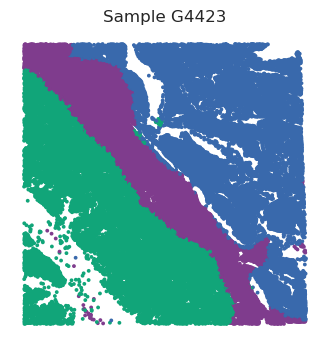

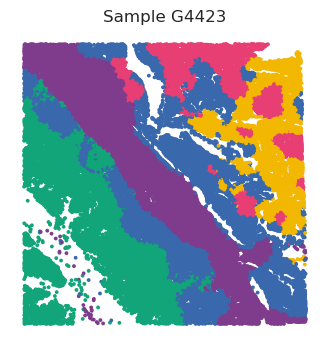

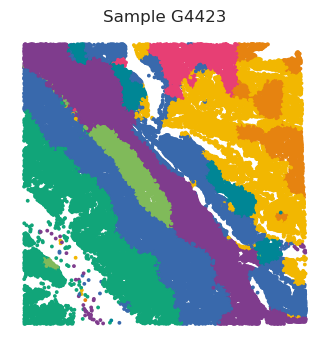

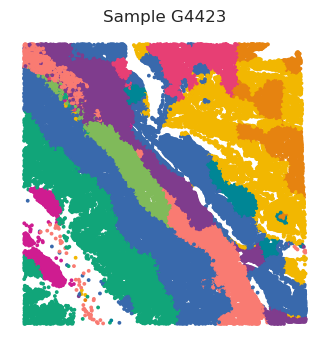

In [24]:
from spatial_lda.visualization import plot_samples_in_a_row
plot_samples_in_a_row(topic_weights_3, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_5, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_8, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_10, plot_bcell_topic_multicolor, df_dict, tumor_set=samples)